In [ ]:
# fmt: off

### Necessary Imports

In [1]:
import numpy as np
from matplotlib import ticker

from rtdip_sdk.pipelines.data_quality import KSigmaAnomalyDetection, IntervalFiltering, ArimaPrediction, MissingValueImputation, NormalizationMean, NormalizationZScore, NormalizationMinMax, Denormalization, DuplicateDetection
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession
import math
import random

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/01/15 18:18:48 WARN Utils: Your hostname, anons-Laptop resolves to a loopback address: 127.0.1.1; using 10.21.37.120 instead (on interface wlo1)
25/01/15 18:18:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/15 18:18:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Introduction

I'm [name], a Data Engineer at Shell. [More Explanation to why to do that.]

### Source of Data

The source data is sourced from the data given from Shell.

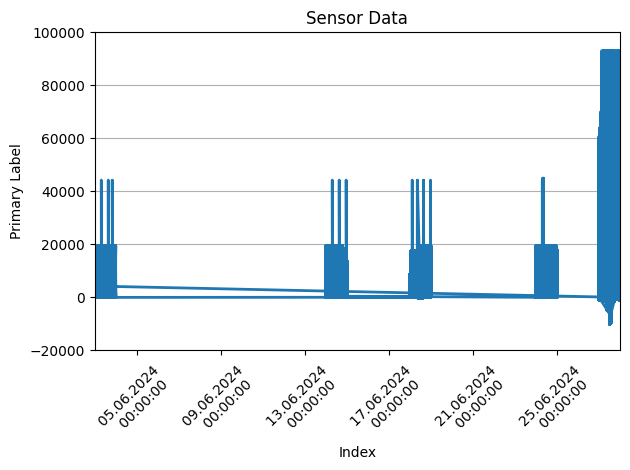

<Figure size 640x480 with 0 Axes>

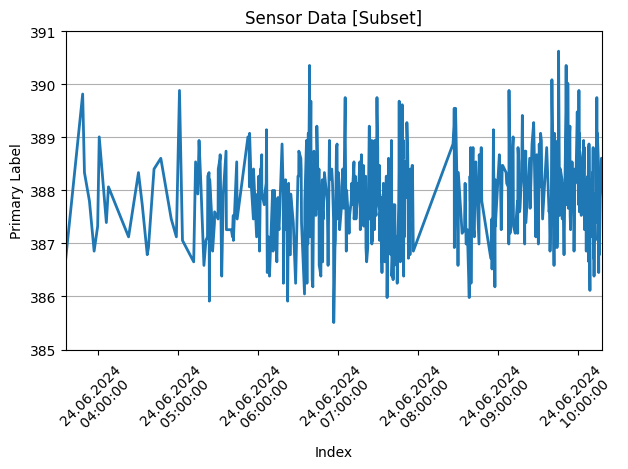

<Figure size 640x480 with 0 Axes>

In [12]:
source_df = pd.read_pickle('./ExampleData.pkl')

def create_value_plot(value_df = None, secondary_value_df = None, title = 'Unnamed Plot', x_label = 'Index', y_label = 'Primary Label', secondary_y_label = 'Secondary Value', share_y_axis = False, ylim = None):
    value_df.index = pd.to_datetime(value_df['EventTime'])
    value_df = value_df['Value']
    if secondary_value_df is not None:
        secondary_value_df.index = pd.to_datetime(secondary_value_df['EventTime'])
        secondary_value_df = secondary_value_df['Value']

    fig, ax = plt.subplots()
    solar_line = ax.plot(value_df, label=y_label, linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y \n %H:%M:%S"))
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim([value_df.min(), value_df.max()] if ylim is None else ylim)
    ax.set_xlim([value_df.index.min(), value_df.index.max()])
    ax.grid(axis='y')

    if secondary_value_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(secondary_y_label, color=color)
        ax2.plot(secondary_value_df, color=color, linewidth=3, linestyle = '--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(ax.get_ylim() if share_y_axis else [secondary_value_df.min(), secondary_value_df.max()])

    fig.tight_layout()
    plt.show()
    plt.clf()

create_value_plot(source_df, title='Sensor Data', ylim=[-20000, 100000])

start_time = pd.to_datetime('2024-06-24 03:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-24 11:00:00', format='%Y-%m-%d %X')

# Slicing by end dates is only possible if index is sorted by time
source_df = source_df[0:1000].sort_index()[start_time:end_time]
create_value_plot(source_df, title='Sensor Data [Subset]', ylim=[385,391])

df_0 = spark_session.createDataFrame(source_df, ['TagName', 'EventTime', 'Status', 'Value'])

### Normalization
*Scenario*:
We want to normalize sensor data, so it better used in other components or Machine Learning applications.
We show our three implemented methods of normalization: Z-score, min-max & mean.
The denormalization of data is also supported, e. g. for storing processed data in a human-readable format.

In [13]:
# Prepare Pipeline Compoment
z_score_norm = NormalizationZScore(df=df_0, column_names=['Value'], in_place=True)
# Execute the normalization on the dataframe
df_1 = z_score_norm.filter()
# Denormalization of Z-Score DF
# denorm = Denormalization(df=z_score_df, normalization_to_revert=z_score_norm)
# z_score_df = z_score_df.toPandas().set_index(april_df.index)
# denorm_df = denorm.filter().toPandas().set_index(april_df.index)

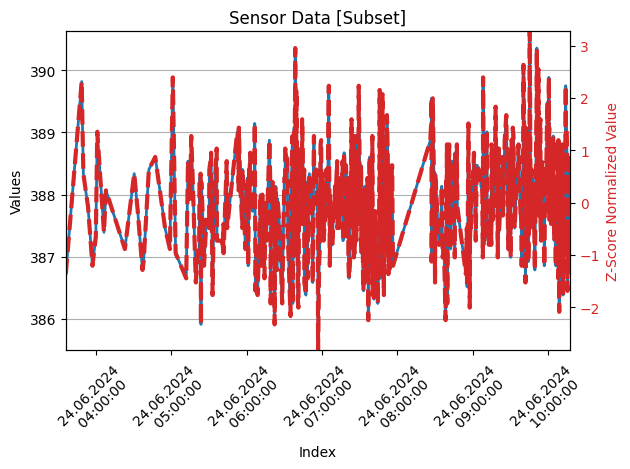

<Figure size 640x480 with 0 Axes>

In [14]:
create_value_plot(value_df=df_0.toPandas(), secondary_value_df=df_1.toPandas(), title='Sensor Data [Subset]', y_label = 'Values',  secondary_y_label='Z-Score Normalized Value')

### Duplicate Detection
*Scenario*:
Because of some error reading in the sensor data, some entries are duplicated.
Cleaning these will decrease the size of the dataframe without losing any information.


In [5]:
df_2 = df_1



### Sigma Anomaly Detection
*Scenario*:
In raw sensor data, there are sometimes measurement outliers or errors, which pollute the data.
Identifying these spikes and removing them improves the data quality.

In [6]:
random.seed(0)
# Execute Pipeline
df_3 = KSigmaAnomalyDetection(spark_session, df=df_2, column_names=['Value'], k_value=2.0, use_median=False).filter()

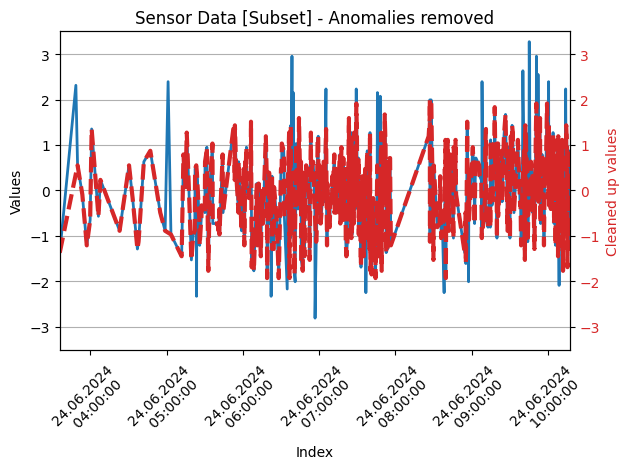

<Figure size 640x480 with 0 Axes>

In [7]:
# Transform Data back into pandas
create_value_plot(value_df=df_2.toPandas(), secondary_value_df=df_3.toPandas(), title='Sensor Data [Subset] - Anomalies removed', share_y_axis=True, y_label = 'Values', secondary_y_label='Cleaned up values', ylim=[-3.5, 3.5])

### Value Imputation
*Scenario*:
Sometimes a value is missing because of sensor error or similar issues. This makes it difficult to use these time series on algorithms expecting a time series without gaps. To fix that issue, Value Imputation is used to fill in these gaps with meaningful values.



In [99]:
random.seed(0)
# Execute Pipeline
df_4 = MissingValueImputation(spark_session, df=df_3, tolerance_percentage=0).filter()


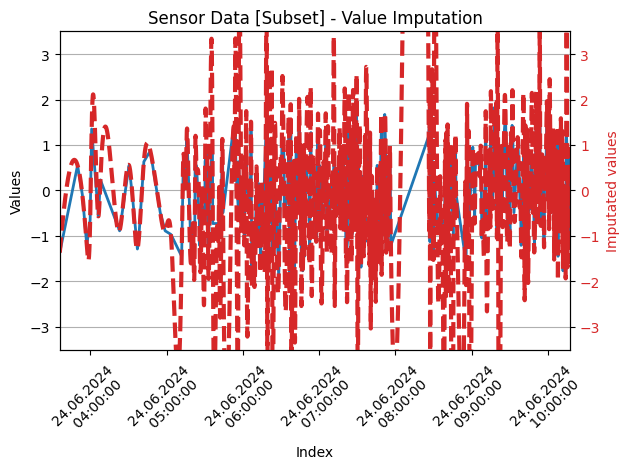

4840


<Figure size 640x480 with 0 Axes>

In [104]:
# Transform Data back into pandas
create_value_plot(value_df=df_3.toPandas(), secondary_value_df=df_4.toPandas(), title='Sensor Data [Subset] - Value Imputation', share_y_axis=True, y_label = 'Values', secondary_y_label='Imputated values', ylim=[-3.5, 3.5])
print(df_4.toPandas().shape[0])

### ARIMA Prediction
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [ ]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
arima_comp_df = output_intf_df.copy(deep=True)
arima_comp_df.drop(arima_comp_df.tail(1).index, inplace=True)
half_size = math.ceil(arima_comp_df.shape[0]/2)
arima_input_df = arima_comp_df.head(half_size)
arima_ps_df = spark_session.createDataFrame(
        arima_input_df,
        ['Solar  - Actual Aggregated [MW]', 'EventTime']
    )
# Pipeline Execution
arima_comp = ArimaPrediction(arima_ps_df, column_name='Solar  - Actual Aggregated [MW]', number_of_data_points_to_analyze=half_size, number_of_data_points_to_predict=half_size,
                             order=(2,0,0), seasonal_order=(5,0,0,half_size/7), trend='n')
forecasted_df = arima_comp.filter().toPandas()
# Postprocessing Data

forecasted_df['value'] = forecasted_df['Solar  - Actual Aggregated [MW]']
forecasted_df['EventTime'] = pd.to_datetime(arima_comp_df.index)
forecasted_df = forecasted_df.set_index('EventTime')

create_normalization_plot(input_df=april_df, normalized_df=forecasted_df.tail(half_size), title='Solar Energy produced in Germany - Prediction with ARIMA', ylabel_2='Forecasted Solar - Actual Aggregated [MW]', share_y_axis=True)
